# Introduction to Data Science
## Fitting mathematical models

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

# I've abstracted some of what we'll be doing today into a library.
# You can take a look at this code if you want by going into `dstools/data_tools.py`
from dstools import data_tools

import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 8

In [2]:
# Get some data
target_name, variable_names, data, Y = data_tools.create_data()

# Grab the predictors
X = data_tools.X()

Let's take a look at our data. We have two features, `humor` and `number_pets`. We will use these to predict whether or not our users are `success`ful.

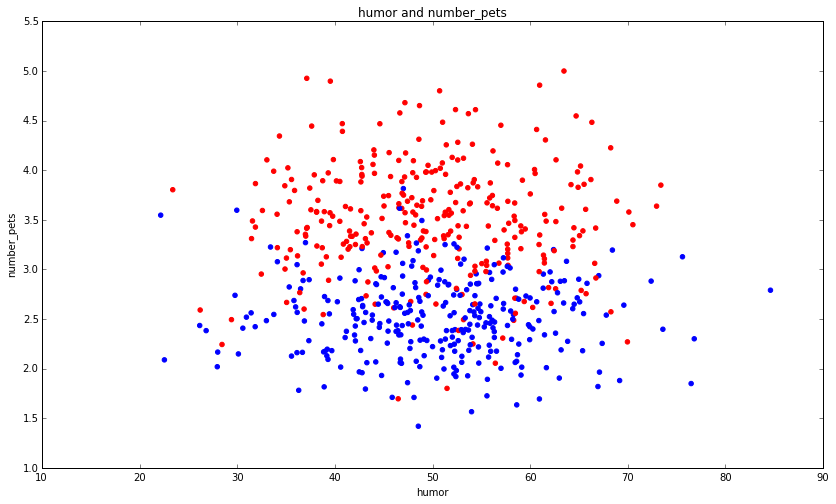

In [3]:
data_tools.Decision_Surface(X, Y, None, surface=False)

### Decision tree classifiers
We can re-explore the modeling technique we learned last class -- decision tree classifiers.

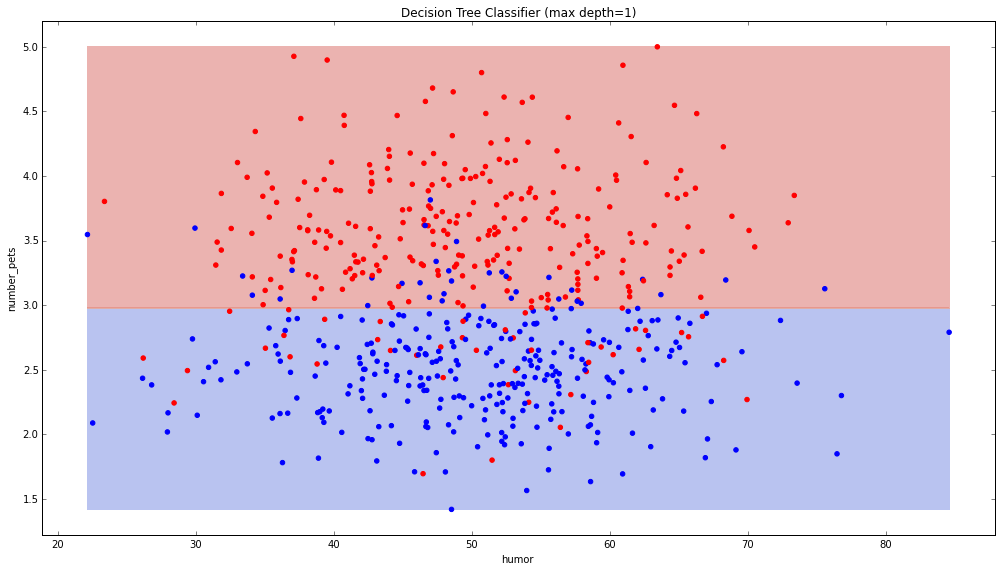

In [4]:
# Settings
depths = [1] # We can also try 4 and 15
show_probabilities = False

position = 1
for depth in depths:
    # Get complex x
    X = data_tools.X()

    # Model
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X, Y) 
    
    # Plot
    plt.subplot(1, len(depths), position)
    position += 1
    data_tools.Decision_Surface(X, Y, model, probabilities=show_probabilities)
    plt.title("Decision Tree Classifier (max depth=" + str(depth) + ")")
plt.tight_layout()
plt.show()

Recall that you can use different max depths to create more complex models. Try it out above!

### Linear discriminant models

Since you've read about linear models now, let's try building one on this data set. Looking at the data above, can you tell where a good linear discriminant would be?

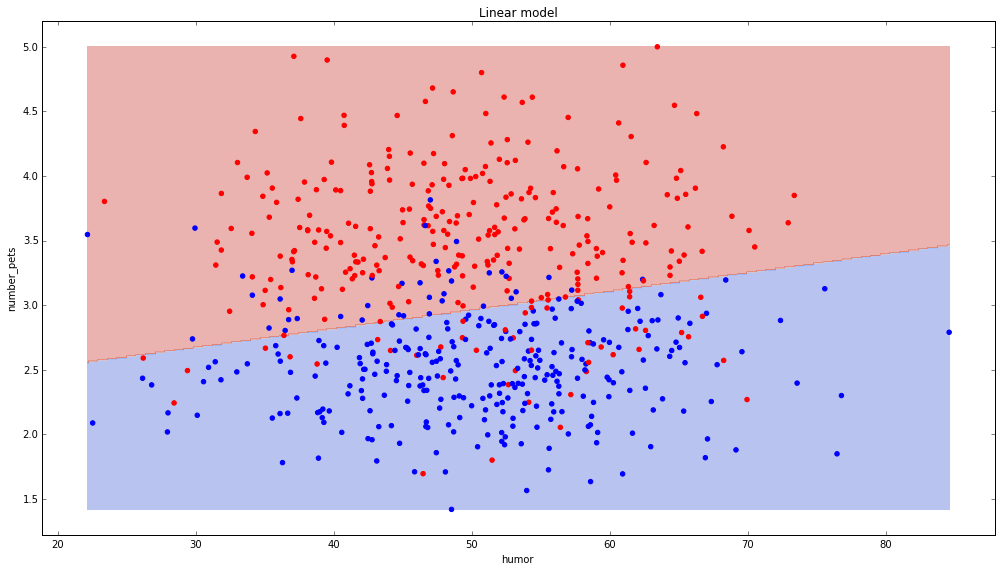

In [5]:
# Settings
show_probabilities = False

# Model
X = data_tools.X()
model = LogisticRegression()
model.fit(X, Y)

# Plot
data_tools.Decision_Surface(X, Y, model, probabilities=show_probabilities)
plt.title("Linear model")
plt.tight_layout()
plt.show()

### Logistic regression

Ok.  We've talked a lot about the need to estimate probabilities.  Last time we discussed how tree models generate probabilities.  How would we generate probabilities from a linear discriminant?  [Let's discuss the derivation of logistic regression -- it's important to understand that.]

Try showing probabilities both for the linear model and the tree classifiers. You can do this by modifying the settings at the top of each code block above (`show_probabilities = True` or `False`).

### Non-linear models

We saw that the tree models could get very complex to fit the data better. One way of doing this was to allow the tree to grow deeper. Deeper trees resulted in cutting the decision surface into smaller and smaller pieces.

Can we use the idea of fitting linear models to generate non-linear boundaries with logistic regression? We can do this by adding in some non linear terms, such as $humor^2$ or $humor^3$.

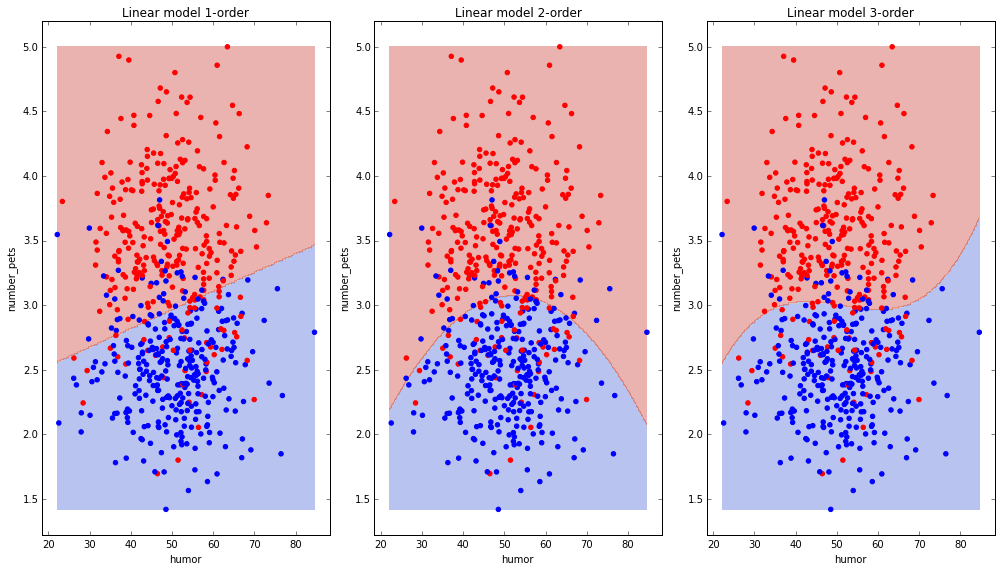

In [6]:
# Settings
max_order = 3 # Maximum of 3
show_probabilities = False

for order in range(1, max_order+1):
    # Get complex x
    X_complex = data_tools.X(order)
    
    # Model
    model = LogisticRegression()
    model.fit(X_complex, Y)
    
    # Plot
    plt.subplot(1, max_order, order)
    data_tools.Decision_Surface(X_complex, Y, model, probabilities=show_probabilities)
    plt.title("Linear model " + str(order) + "-order")
plt.tight_layout()
plt.show()

Of course, we can also look at the probabilities on these surfaces. Try it out above!

### Function fitting, more generally

Let's take a step back and talk more generally about fitting functions to data...  [Class discussion.]

But...  we're still "just" fitting the *training* data.

### Generalization

What we want are models that **generalize** to data that were not used to build them! Do we even know how well our models generalize? Why is this important?

Let's apply this concept to our data. Now, before we fit out models, we can set aside some data to be used later for testing. The benefit of holding out data is that our model can't simply memorize everything! Let's use sklearn to set aside some data.

In [7]:
# Set randomness so that we all get the same answer
np.random.seed(841)

# Split the data into train and test pieces for both X and Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80)

Now that we have split our data, let's revisit the tree based classifier we discussed in our last class. We can start by checking how well a model does when it is fit on a "training" set and then used to predict on both the training set as well as our hold out set. Remember, the model has never seen this hold out "test" set before!

In [8]:
# Model
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, Y_train)

print "Accuracy on training = %.3f" % metrics.accuracy_score(model.predict(X_train), Y_train)
print "Accuracy on test = %.3f" % metrics.accuracy_score(model.predict(X_test), Y_test)

Accuracy on training = 0.892
Accuracy on test = 0.792


The results on the test set were worse. Why is this? Can it ever do beter?

If you remember, last week we saw that as we let our tree get deeper and deeper, we eventually achieved 100% accuracy. Can we do this on the test data? What happens as our tree gets more and more complicated?

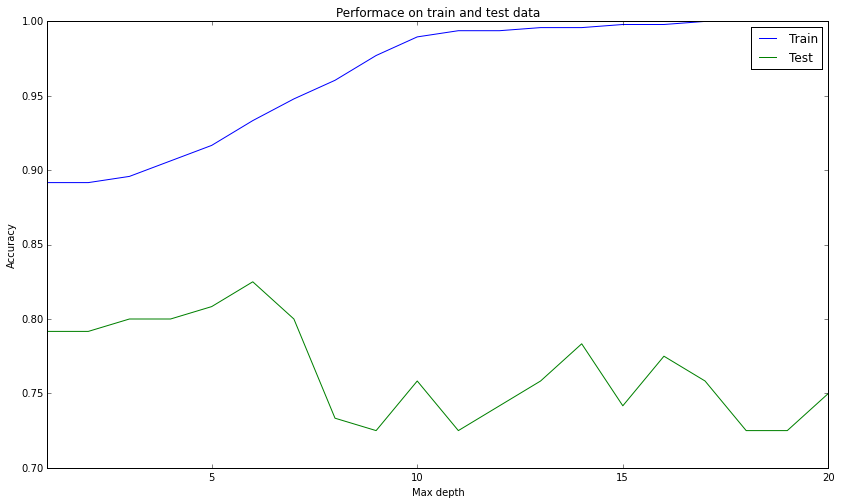

In [17]:
accuracies_train = []
accuracies_test = []
depths = range(1, 21)

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    accuracies_train.append(metrics.accuracy_score(model.predict(X_train), Y_train))
    accuracies_test.append(metrics.accuracy_score(model.predict(X_test), Y_test))

plt.plot(depths, accuracies_train, label="Train")
plt.plot(depths, accuracies_test, label="Test")
plt.title("Performace on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.ylim([0.70, 1.0])
plt.xlim([1,20])
plt.legend()
plt.show()

### Cross validation

Above, we made a single train/test split. We set aside 20% of our data and *never* used it for training. We also never used the 80% of the data set aside for training to test generalizability. How can we make better use of our data so that we can utilize it more fully when training and testing?

Instead of only making the split once, let's use cross validation so that every record can contribute to training as well as testing in some way.

In [16]:
# Model
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, Y_train)

print "Cross validation accuracy on training = %.3f" % np.mean(cross_validation.cross_val_score(model, X, Y))

Cross validation accuracy on training = 0.842


We can add this to our plot from above.

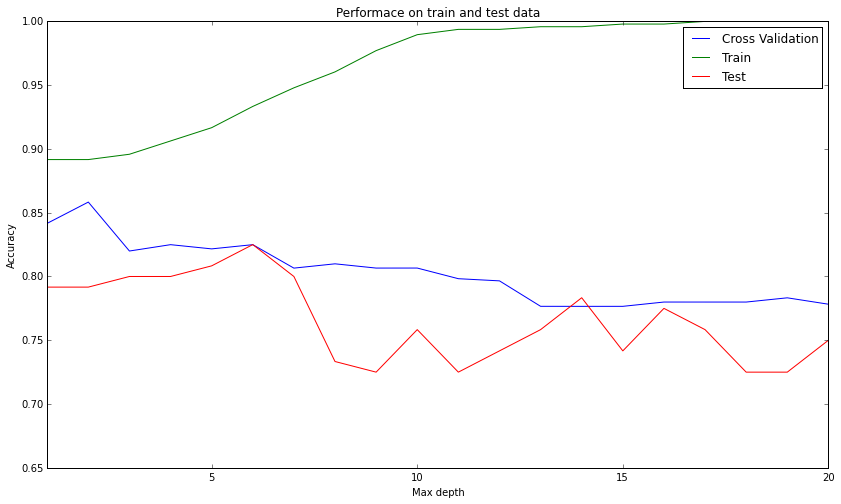

In [21]:
accuracies_cross_validation = []
depths = range(1, 21)

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    
    accuracies_cross_validation.append(np.mean(cross_validation.cross_val_score(model, X, Y)))

plt.plot(depths, accuracies_cross_validation, label="Cross Validation")
plt.plot(depths, accuracies_train, label="Train")
plt.plot(depths, accuracies_test, label="Test")
plt.title("Performace on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.ylim([0.65, 1.0])
plt.xlim([1,20])
plt.legend()
plt.show()

### Hyper parameter tuning

What we did above was tune a hyper parameter (in this case we were looking at `max_depth`, although you could also look at `min_samples_leaf` and `min_samples_split`) of the tree classifier model. What can we tune when it comes to linear discrminant classifiers like logistic regression?

In [71]:
# EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA
# r = range(-6, 6)
# max_complexity = len(r)
# for complexity in r:
#     # Get complex x
#     X = data_tools.X()
    
#     # Model
#     model = SVC(kernel="linear", C=np.power(10.0, complexity))
#     model.fit(X, Y) 
    
#     # Plot
#     plt.subplot(3, max_complexity/3, complexity+6)
#     plt.text(40, 2, str(complexity))
#     data_tools.Decision_Surface(X, Y, model)
# plt.tight_layout()
# plt.show()
# EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA EXTRA